# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data?resource=download . Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [46]:
# Your code here
import pandas as pd
fraud = pd.read_csv("Fraud.csv")
fraud =fraud.sample(100000)
fraud.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
262529,15,CASH_OUT,14947.68,C1155350947,216.00,0.00,C1188229244,1107349.93,1122297.61,0,0
463678,19,CASH_IN,97553.13,C1371961662,50649.00,148202.13,C1126014379,723606.46,806237.88,0,0
3564559,260,CASH_IN,323430.80,C58462371,3147521.82,3470952.61,C1360489642,1523100.44,1199669.65,0,0


### What is the distribution of the outcome? 

In [156]:
# Your response here
fraud['isFraud'].value_counts()

0    99847
1      153
Name: isFraud, dtype: int64

### Clean the dataset. Pre-process it to make it suitable for ML training. Feel free to explore, drop, encode, transform, etc. Whatever you feel will improve the model score.

In [157]:
# Your code here
fraud.reset_index(drop=True, inplace=True)
print(fraud.dtypes)
print(fraud.isnull().sum())
print(fraud.describe())
print(fraud['isFraud'].value_counts())



step                    int64
type                   object
amount                float64
nameOrig               object
oldbalanceOrg         float64
newbalanceOrig        float64
nameDest               object
oldbalanceDest        float64
newbalanceDest        float64
isFraud                 int64
isFlaggedFraud          int64
type_mapped             int64
without_oldbalance      int64
without_newbalance      int64
dtype: object
step                  0
type                  0
amount                0
nameOrig              0
oldbalanceOrg         0
newbalanceOrig        0
nameDest              0
oldbalanceDest        0
newbalanceDest        0
isFraud               0
isFlaggedFraud        0
type_mapped           0
without_oldbalance    0
without_newbalance    0
dtype: int64
                step        amount  oldbalanceOrg  newbalanceOrig  \
count  100000.000000  1.000000e+05   1.000000e+05    1.000000e+05   
mean      243.263930  1.793573e+05   8.428866e+05    8.640810e+05   
std       

In [158]:
mismos_valores = fraud['isFraud'].equals(fraud['isFlaggedFraud'])

# Imprimir el resultado
if mismos_valores:
    print("'isFraud' and 'isFlaggedFraud' are not different.")
else:
    print("'isFraud' and 'isFlaggedFraud' are different.")

'isFraud' and 'isFlaggedFraud' are different.


Description of variables:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction."

)

In [159]:
fraud_fraud = fraud[fraud['isFraud']==1]
fraud_fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_mapped,without_oldbalance,without_newbalance
count,153.000000,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02,153.0,153.0,153.0,153.000000,153.000000
mean,373.084967,1.327587e+06,1.549045e+06,2.214583e+05,3.581099e+05,8.864076e+05,1.0,0.0,1.0,0.006536,0.006536
std,227.231564,2.203774e+06,3.720105e+06,2.261887e+06,1.261737e+06,2.095600e+06,0.0,0.0,0.0,0.080845,0.080845
min,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,1.0,0.000000,0.000000
25%,190.000000,1.432758e+05,1.432758e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,1.0,0.000000,0.000000
50%,358.000000,4.709222e+05,4.709222e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,1.0,0.000000,0.000000
75%,581.000000,1.367071e+06,1.367071e+06,0.000000e+00,1.472516e+05,9.270781e+05,1.0,0.0,1.0,0.000000,0.000000
max,741.000000,1.000000e+07,3.767004e+07,2.767004e+07,1.364687e+07,1.472918e+07,1.0,0.0,1.0,1.000000,1.000000


In [160]:
fraud_no_fraud = fraud[fraud['isFraud']==0]
fraud_no_fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_mapped,without_oldbalance,without_newbalance
count,99847.000000,9.984700e+04,9.984700e+04,9.984700e+04,9.984700e+04,9.984700e+04,99847.0,99847.0,99847.000000,99847.000000,99847.000000
mean,243.064999,1.775978e+05,8.418045e+05,8.650658e+05,1.105966e+06,1.226070e+06,0.0,0.0,0.435316,0.331507,0.331507
std,141.879857,5.945533e+05,2.905528e+06,2.944180e+06,3.336975e+06,3.587248e+06,0.0,0.0,0.495801,0.470757,0.470757
min,1.000000,1.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000,0.000000
25%,155.000000,1.342613e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000,0.000000
50%,238.000000,7.506650e+04,1.422400e+04,0.000000e+00,1.353959e+05,2.157500e+05,0.0,0.0,0.000000,0.000000,0.000000
75%,333.000000,2.082061e+05,1.070895e+05,1.431083e+05,9.575898e+05,1.125503e+06,0.0,0.0,1.000000,1.000000,1.000000
max,718.000000,7.382349e+07,3.500286e+07,3.501738e+07,1.746343e+08,1.956882e+08,0.0,0.0,1.000000,1.000000,1.000000


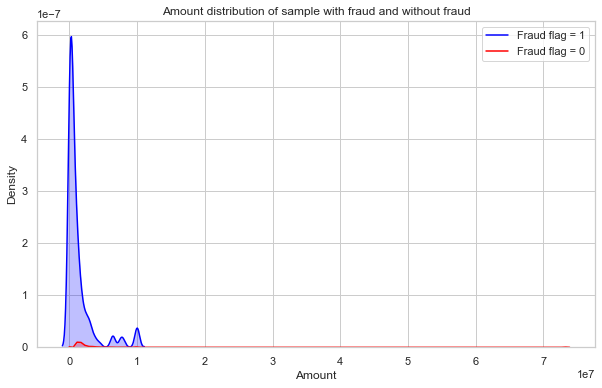

Fraud transaction are normally with less amount, more homogenious. Normal transaction is not so homogenious.
mean of the amount of fraud transactions: 1327586.5471895428
mean of the amount of fraud transactions: 1327586.5471895428 Percentile 80: 1664758.864
mean of the amount of no fraud transactions: 177597.77058629962 Percentile 80: 246382.89200000005


In [161]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['amount'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['amount'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Amount distribution of sample with fraud and without fraud')
plt.xlabel('Amount')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
percentile_80 = np.percentile(fraud_fraud['amount'], 80)
print('Fraud transaction are normally with less amount, more homogenious. Normal transaction is not so homogenious.')
print('mean of the amount of fraud transactions:',fraud_fraud['amount'].mean())


# Imprimir el percentil 80%
print('mean of the amount of fraud transactions:',fraud_fraud['amount'].mean(),'Percentile 80:',np.percentile(fraud_fraud['amount'], 80))
print('mean of the amount of no fraud transactions:',fraud_no_fraud['amount'].mean(),'Percentile 80:',np.percentile(fraud_no_fraud['amount'], 80))

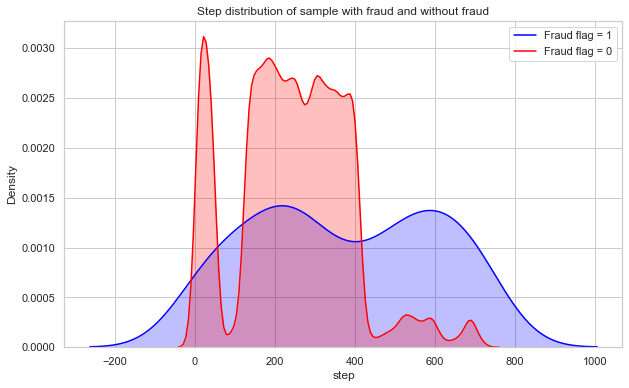

not so intuitive


In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['step'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['step'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Step distribution of sample with fraud and without fraud')
plt.xlabel('step')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
print('not so intuitive')

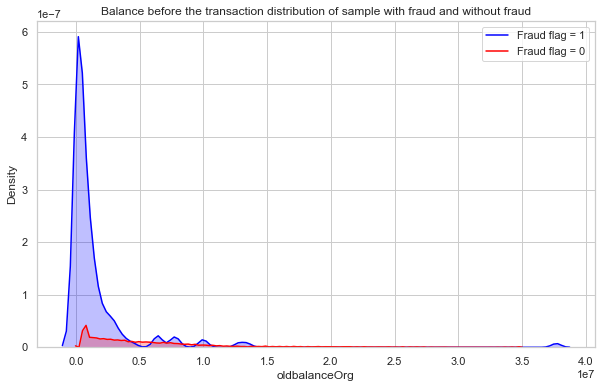

mean of the balance before transactions  of fraud transactions: 1549044.870326798 Percentile 90: 3062506.58
mean of the balance before transactions  of no fraud transactions: 841804.5418861868 Percentile 90: 1893251.0120000008
Very intuitive, less balance in the origin account before fraud


In [163]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['oldbalanceOrg'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['oldbalanceOrg'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Balance before the transaction distribution of sample with fraud and without fraud')
plt.xlabel('oldbalanceOrg')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
print('mean of the balance before transactions  of fraud transactions:',fraud_fraud['oldbalanceOrg'].mean(),'Percentile 90:',np.percentile(fraud_fraud['oldbalanceOrg'], 90))
print('mean of the balance before transactions  of no fraud transactions:',fraud_no_fraud['oldbalanceOrg'].mean(),'Percentile 90:',np.percentile(fraud_no_fraud['oldbalanceOrg'], 90)
     )
print('Very intuitive, less balance in the origin account before fraud')

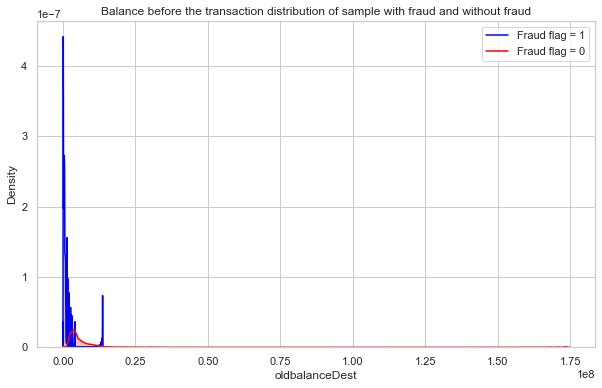

mean of the balance in dest. before transactions  of fraud transactions: 358109.864117647 Percentile 90: 894593.6740000006
mean of the balance before transactions in dest.  of no fraud transactions: 1105966.0199242888 Percentile 90: 2943850.132000002
Very intuitive, less balance in dest. for fraud transactions


In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['oldbalanceDest'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['oldbalanceDest'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Balance before the transaction distribution of sample with fraud and without fraud')
plt.xlabel('oldbalanceDest')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
print('mean of the balance in dest. before transactions  of fraud transactions:',fraud_fraud['oldbalanceDest'].mean(),'Percentile 90:',np.percentile(fraud_fraud['oldbalanceDest'], 90))
print('mean of the balance before transactions in dest.  of no fraud transactions:',fraud_no_fraud['oldbalanceDest'].mean(),'Percentile 90:',np.percentile(fraud_no_fraud['oldbalanceDest'], 90)
     )
print('Very intuitive, less balance in dest. for fraud transactions')

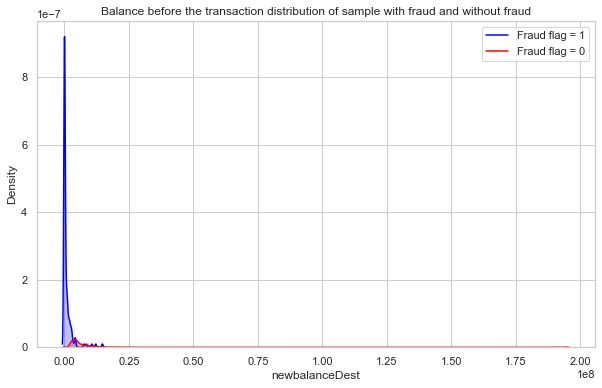

mean of the balance in dest. after transactions  of fraud transactions: 886407.6390849671 Percentile 90: 2389927.098000002
mean of the balance after transactions in dest.  of no fraud transactions: 1226070.1473120868 Percentile 90: 3219829.668
Very intuitive, less balance in dest. for fraud transactions


In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['newbalanceDest'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['newbalanceDest'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Balance before the transaction distribution of sample with fraud and without fraud')
plt.xlabel('newbalanceDest')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
print('mean of the balance in dest. after transactions  of fraud transactions:',fraud_fraud['newbalanceDest'].mean(),'Percentile 90:',np.percentile(fraud_fraud['newbalanceDest'], 90))
print('mean of the balance after transactions in dest.  of no fraud transactions:',fraud_no_fraud['newbalanceDest'].mean(),'Percentile 90:',np.percentile(fraud_no_fraud['newbalanceDest'], 90)
     )
print('Very intuitive, less balance in dest. for fraud transactions')

In [166]:
print(fraud_fraud['type'].unique())
print(fraud_no_fraud['type'].unique())

['TRANSFER' 'CASH_OUT']
['CASH_OUT' 'CASH_IN' 'PAYMENT' 'TRANSFER' 'DEBIT']


In [190]:
label_mapping = {'PAYMENT': 0, 'CASH_IN': 0, 'CASH_OUT': 1, 'TRANSFER': 1, 'DEBIT': 0}

# Aplicar el mapeo al DataFrame
fraud['type_mapped'] = fraud['type'].map(label_mapping)

# Ahora puedes binarizar la columna type_mapped
# Define los límites de los bins
bins = [0, 1]  # Los límites de los bins deben incluir todos los valores posibles, más un límite adicional para el final

# Etiquetas para los bins
bin_labels = ['Bin1', 'Bin2', 'Bin3', 'Bin4', 'Bin5']

In [191]:
fraud_fraud = fraud[fraud['isFraud']==1]
fraud_no_fraud = fraud[fraud['isFraud']==0]


In [192]:
fraud.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_mapped', 'without_oldbalance',
       'without_newbalance'],
      dtype='object')

In [193]:


# Assuming filtered_fraud_old contains the filtered DataFrame
filtered_fraud_old = fraud[fraud['oldbalanceOrg'] == 0]

# Create a new column 'isFraud_old' in the fraud DataFrame
fraud['without_oldbalance'] = 0  # Initialize with 0
fraud.loc[filtered_fraud_old.index, 'without_oldbalance'] = 1  # Set 1 for the filtered rows

# Display unique values of 'isFraud_old'
print(fraud['without_oldbalance'].unique())

[0 1]


In [194]:

# Assuming filtered_fraud_old contains the filtered DataFrame
filtered_fraud_new = fraud[fraud['newbalanceOrig'] == 0]

# Create a new column 'isFraud_old' in the fraud DataFrame
fraud['without_newbalance'] = 0  # Initialize with 0
fraud.loc[filtered_fraud_old.index, 'without_newbalance'] = 1  # Set 1 for the filtered rows

# Display unique values of 'isFraud_old'
print(fraud['without_newbalance'].unique())

[0 1]


In [205]:
fraud['critical_situation']=fraud['without_newbalance']+fraud['without_oldbalance']
fraud['critical_situation'].unique()

array([0, 2], dtype=int64)

### Run a logisitc regression classifier and evaluate its accuracy.

In [195]:
print('Candidate variables: step, amount and choosing one of these, as there are correlated:newbalanceDest,oldbalanceDest')
print(fraud.columns)  # Imprimir los nombres de las columnas
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression


Candidate variables: step, amount and choosing one of these, as there are correlated:newbalanceDest,oldbalanceDest
Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_mapped', 'without_oldbalance',
       'without_newbalance'],
      dtype='object')


In [196]:

X_A = fraud[['type_mapped','isFlaggedFraud','without_newbalance','without_oldbalance','nameDest','nameOrig','isFraud']]
#'amount', 'oldbalanceOrg', 'oldbalanceDest'
y_A = fraud['isFraud']
from sklearn.model_selection import train_test_split
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A)


X_train_A['Fraud_Relation_Name']=X_train_A['nameDest']+X_train_A['nameOrig']
fraud_rel = X_train_A.groupby('Fraud_Relation_Name')['isFraud'].max()

X_train_A['Fraud_rel'] = X_train_A['Fraud_Relation_Name'].map(fraud_rel)

X_test_A['Fraud_Relation_Name']=X_test_A['nameDest']+X_test_A['nameOrig']
X_test_A['Fraud_rel'] = X_test_A['Fraud_Relation_Name'].map(fraud_rel)
X_train_A=X_train_A[['type_mapped','isFlaggedFraud','Fraud_rel']]
X_test_A=X_test_A[['type_mapped','isFlaggedFraud','Fraud_rel']]

C:\Users\rozio\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rozio\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rozio\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Assuming these are already defined
# X_A = fraud[['type_mapped','isFlaggedFraud','nameDest','nameOrig','isFraud']]
# y_A = fraud['isFraud']

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A)

# Creating engineered features
X_train_A['Fraud_Relation_Name'] = X_train_A['nameDest'] + X_train_A['nameOrig']
fraud_rel = X_train_A.groupby('Fraud_Relation_Name')['isFraud'].max()
X_train_A['Fraud_rel'] = X_train_A['Fraud_Relation_Name'].map(fraud_rel)

X_test_A['Fraud_Relation_Name'] = X_test_A['nameDest'] + X_test_A['nameOrig']
X_test_A['Fraud_rel'] = X_test_A['Fraud_Relation_Name'].map(fraud_rel)

# Selecting relevant features
X_train_A = X_train_A[['type_mapped', 'isFlaggedFraud', 'Fraud_rel','without_newbalance','without_oldbalance']]
X_test_A = X_test_A[['type_mapped', 'isFlaggedFraud', 'Fraud_rel','without_newbalance','without_oldbalance']]



C:\Users\rozio\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\rozio\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rozio\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [198]:
from sklearn.impute import SimpleImputer

# Handle missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_A_imputed = imputer.fit_transform(X_train_A)
X_test_A_imputed = imputer.transform(X_test_A)

# Training Logistic Regression Model
Regression_Model_A = LogisticRegression(max_iter=1000)
Regression_Model_A.fit(X_train_A_imputed, y_train_A)

# Evaluating the model
print('Model A SCORE:', Regression_Model_A.score(X_test_A_imputed, y_test_A))
y_pred_A = Regression_Model_A.predict(X_test_A_imputed)
print("Precision Model A:", precision_score(y_test_A, y_pred_A))
print("Recall Model A:", recall_score(y_test_A, y_pred_A))
print("F1-score Model A:", f1_score(y_test_A, y_pred_A))
print("Confusion Matrix:")
print(confusion_matrix(y_test_A, y_pred_A))

Model A SCORE: 0.99828
Precision Model A: 0.0
Recall Model A: 0.0
F1-score Model A: 0.0
Confusion Matrix:
[[24957     0]
 [   43     0]]


C:\Users\rozio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [199]:
X_B = fraud[['type_mapped','without_oldbalance','without_newbalance']]
y_B = fraud['isFraud']

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B)


Regression_Model_B = LogisticRegression(max_iter=1000)
Regression_Model_B.fit(X_train_B, y_train_B)
print('Model B SCORE:', Regression_Model_B.score(X_test_B, y_test_B))

# Calcular precisión, recall y F1-score para el modelo B
y_pred_B = Regression_Model_B.predict(X_test_B)
print("Precision Model B:", precision_score(y_test_B, y_pred_B))
print("Recall Model B:", recall_score(y_test_B, y_pred_B))
print("F1-score Model B:", f1_score(y_test_B, y_pred_B))

Model B SCORE: 0.99824
Precision Model B: 0.0
Recall Model B: 0.0
F1-score Model B: 0.0


C:\Users\rozio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [262]:
X_C = fraud[['critical_situation','type_mapped','nameOrig','nameDest','amount','isFlaggedFraud','isFraud']]
y_C = fraud['isFraud']
#'without_oldbalance',
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C)



# Creating engineered features
X_train_C['Fraud_Relation_Name'] = X_train_C['nameDest'] + X_train_C['nameOrig']
fraud_rel = X_train_C.groupby('Fraud_Relation_Name')['isFraud'].max()
X_train_C['Fraud_rel'] = X_train_C['Fraud_Relation_Name'].map(fraud_rel)

X_test_C['Fraud_Relation_Name'] = X_test_C['nameDest'] + X_test_C['nameOrig']
X_test_C['Fraud_rel'] = X_test_C['Fraud_Relation_Name'].map(fraud_rel)

# Selecting relevant features
X_train_C = X_train_C[[  'critical_situation']]
X_test_C = X_test_C[[ 'critical_situation']]
imputer = SimpleImputer(strategy='constant', fill_value=0)  # Or any other strategy you prefer
X_train_C_imputed = imputer.fit_transform(X_train_C)
X_test_C_imputed = imputer.transform(X_test_C)

Regression_Model_C = LogisticRegression(max_iter=1000)
Regression_Model_C.fit(X_train_C_imputed, y_train_C)

# Evaluating the model
print('Model C SCORE:', Regression_Model_C.score(X_test_C_imputed, y_test_C))
y_pred_C = Regression_Model_C.predict(X_test_C_imputed)
print("Precision Model C:", precision_score(y_test_C, y_pred_C))
print("Recall Model C:", recall_score(y_test_C, y_pred_C))
print("F1-score Model C:", f1_score(y_test_C, y_pred_C))

C:\Users\rozio\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\rozio\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rozio\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Model C SCORE: 0.99884
Precision Model C: 0.0
Recall Model C: 0.0
F1-score Model C: 0.0


C:\Users\rozio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [235]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_B,y_pred_B)

array([[24956,     0],
       [   44,     0]], dtype=int64)

In [236]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_A,y_pred_A)

array([[24957,     0],
       [   43,     0]], dtype=int64)

In [263]:

confusion_matrix(y_test_C,y_pred_C)

array([[24971,     0],
       [   29,     0]], dtype=int64)

In [238]:
fraud.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_mapped', 'without_oldbalance',
       'without_newbalance', 'critical_situation'],
      dtype='object')

# Oversamping over "C" approach :

In [264]:
from sklearn.utils import resample
train = pd.concat([X_train_C, y_train_C],axis=1)
display(train.shape)
train.head()


(75000, 2)

,critical_situation,isFraud
90413,0,0
48588,0,0
78035,0,0
95784,0,1
66195,0,0


In [265]:
yes_fraud = train[train['isFraud']==1]
no_fraud = train[train['isFraud']==0]
display(yes_fraud.shape)
display(no_fraud.shape)

(124, 2)

(74876, 2)

In [266]:
yes_fraud_oversampled = resample(yes_fraud, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_fraud),#<- make both sets the same size
                                    random_state=0)
display(yes_fraud_oversampled.shape)

(74876, 2)

In [267]:
train_oversampled = pd.concat([no_fraud,yes_fraud_oversampled])
train_oversampled.head()

,critical_situation,isFraud
90413,0,0
48588,0,0
78035,0,0
66195,0,0
62313,2,0


In [282]:
y_train_over = train_oversampled[['isFraud']]
X_train_over = train_oversampled[['critical_situation']]

# Handle missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)  
X_train_over_imputed = imputer.fit_transform(X_train_over)
X_test_C_imputed = imputer.transform(X_test_C)

# Train Logistic Regression Model
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_over_imputed, y_train_over.values.ravel())  # Convert y_train_over to a 1D array

# Predict using the trained model
pred = LR.predict(X_test_C_imputed)

# Print evaluation metrics
print("Precision: ", precision_score(y_test_C, pred))
print("Recall: ", recall_score(y_test_C, pred))
print("F1-score: ", f1_score(y_test_C, pred))
print('Model B OVERSAMPLED SCORE:', LR.score(X_test_C_imputed, y_test_C))

# Compute and print confusion matrix
cm = confusion_matrix(y_test_C, pred)
print("Confusion Matrix:")
print(cm)

Precision:  0.0017379839386311878
Recall:  1.0
F1-score:  0.0034699371821717024
Model B OVERSAMPLED SCORE: 0.33372
Confusion Matrix:
[[ 8314 16657]
 [    0    29]]


# Decision Tree option:

In [269]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix
imputer = SimpleImputer(strategy='constant', fill_value=0)   # You can use other strategies as well

# Fit the imputer on the training data and transform both the training and test data
X_train_over_imputed = imputer.fit_transform(X_train_over)
X_test_C_imputed = imputer.transform(X_test_C)
# Assuming train_oversampled contains both features (X_train_over) and target (y_train_over)

# Create and fit the decision tree model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_over_imputed, y_train_over)


# Make predictions on the test set
pred_tree = tree_model.predict(X_test_C_imputed)

# Print evaluation metrics
print("Precision:", precision_score(y_test_C, pred_tree))
print("Recall:", recall_score(y_test_C, pred_tree))

# Compute and print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_C, pred_tree))

Precision: 0.0017379839386311878
Recall: 1.0
Confusion Matrix:
[[ 8314 16657]
 [    0    29]]


# Undersampling over "C" approach:

In [273]:
no_fraud_undersampled = resample(no_fraud, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(yes_fraud),#<- make both sets the same size
                                    random_state=0)
display(no_fraud_undersampled.shape)

(124, 2)

In [274]:
train_undersampled = pd.concat([yes_fraud,no_fraud_undersampled])
train_undersampled.head()

,critical_situation,isFraud
95784,0,1
28641,0,1
99292,0,1
3080,0,1
29558,0,1


In [276]:
y_train_under = train_undersampled[['isFraud']]
X_train_under = train_undersampled[['critical_situation']]
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_under, y_train_under)
pred = LR.predict(X_test_C)

print("precision: ",precision_score(y_test_C,pred))
print("recall: ",recall_score(y_test_C,pred))
print("f1: ",f1_score(y_test_C,pred))
print('Model B UNDERSAMPLED SCORE:',LR.score(X_test_C, y_test_C))


confusion_matrix(y_test_C,pred)

precision:  0.0017379839386311878
recall:  1.0
f1:  0.0034699371821717024
Model B UNDERSAMPLED SCORE: 0.33372


C:\Users\rozio\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 8314, 16657],
       [    0,    29]], dtype=int64)

### Now pick a model of your choice and evaluate its accuracy.

Precision for class 0: 0.0
Recall for class 0: 0.0
Precision for class 1: 1.0
Recall for class 1: 1.0


C:\Users\rozio\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


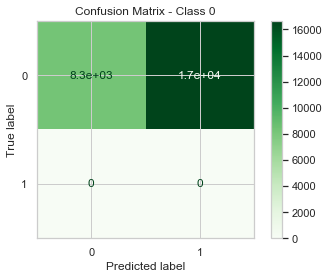

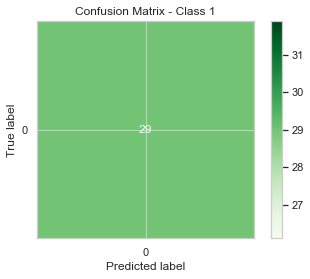

In [283]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test_C, pred)

# Separate predictions and ground truth labels for each class
pred_class_0 = pred[y_test_C == 0]
y_test_class_0 = y_test_C[y_test_C == 0]

pred_class_1 = pred[y_test_C == 1]
y_test_class_1 = y_test_C[y_test_C == 1]

# Calculate confusion matrices for each class
cm_class_0 = confusion_matrix(y_test_class_0, pred_class_0)
cm_class_1 = confusion_matrix(y_test_class_1, pred_class_1)

# Calculate precision and recall for each class
precision_0 = precision_score(y_test_class_0, pred_class_0)
recall_0 = recall_score(y_test_class_0, pred_class_0)

precision_1 = precision_score(y_test_class_1, pred_class_1)
recall_1 = recall_score(y_test_class_1, pred_class_1)

# Print precision and recall for each class
print("Precision for class 0:", precision_0)
print("Recall for class 0:", recall_0)
print("Precision for class 1:", precision_1)
print("Recall for class 1:", recall_1)

# Plot the confusion matrix for class 0
disp_class_0 = ConfusionMatrixDisplay(confusion_matrix=cm_class_0, display_labels=[0, 1])
disp_class_0.plot(cmap='Greens')
plt.title('Confusion Matrix - Class 0')
plt.show()

# Plot the confusion matrix for class 1
disp_class_1 = ConfusionMatrixDisplay(confusion_matrix=cm_class_1, display_labels=[0, 1])
disp_class_1.plot(cmap='Greens')
plt.title('Confusion Matrix - Class 1')
plt.show()

### Which model worked better and how do you know?

In [281]:
# Your response here
print('Model C under or oversampled. It is obtained with both options similar results: very good recall and bad precision but for cases of fraud, as it is a sensible topic, recall is prefered')

Model C under or oversampled. It is obtained with both options similar results: very good recall and bad precision but for cases of fraud, as it is a sensible topic, recall is prefered


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.